# Sanity check: velocity calculations

The purpose of this notebook is to make sure that the range_diff function is implemented correctly. We have already expanded it to be operable on a multidimensional array. Now, the goal is to make sure that the calculations align with more established methods. We will be attempting to compare with results from Irena Vankova's MATLAB ApRES processing scripts.

In [1]:
# Setting up environment
import sys
import pandas as pd
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    15:52:35 	 ApRESDefs.py @function _setup_logging line 490 - Stream logging level set to DEBUG
DEBUG    15:52:35 	 ApRESDefs.py @function _setup_logging line 491 - Add console handler to logger
DEBUG    15:52:35 	 ApRESDefs.py @function _setup_logging line 504 - File logging level set to DEBUG


In [2]:
# Loading site data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")


In [3]:
# Set up dask cluster to help with computation
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34957")
client

Connection method: Direct,
Dashboard: /user/glugeorge/proxy/8787/status,
Comm: tcp://127.0.0.1:34957,Workers: 0
Dashboard: /user/glugeorge/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Comparing consecutive stacked bursts from 2 files

I've downloaded two files from the month of June. After some manual checking, I've found the first burst of the first file aligns with t=954, while the last burst of the second file aligns with t=1141. We load this in for station A101.

In [9]:
timeseries = ds_104.isel(attenuator_setting_pair = 0,time=range(954,1142)).profile_stacked.compute()


Now, let's calculate the velocities between each burst. We basically need to stagger the timeframes that we select by 1.

In [10]:
b1 = timeseries.isel(time=range(0,len(timeseries.time)-1)).where(timeseries.profile_range >= 10,drop=True)
b2 = timeseries.isel(time=range(1,len(timeseries.time))).where(timeseries.profile_range >= 10,drop=True)

This will give the range difference between each burst, without any phase wrapping. We use a correlation window and step of 10.

In [11]:
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)

INFO     14:50:56 	 ApRESDefs.py @function generate_range_diff line 545 - Time between bursts : [878. 899. 897. 889. 901. 900. 899. 901. 900. 900. 930. 869. 900. 900.
 900. 930. 877. 923. 870. 907. 900. 904. 896. 901. 899. 923. 877. 892.
 908. 894. 900. 900. 900. 903. 897. 900. 900. 900. 900. 912. 892. 897.
 900. 900. 901. 899. 900. 900. 899. 900. 900. 901. 899. 900. 900. 900.
 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.
 900. 900. 901. 905. 908. 918. 867. 900. 903. 899. 900. 900. 899. 901.
 902. 898. 905. 899. 903. 894. 899. 901. 899. 900. 900. 900. 900. 900.
 900. 900. 934. 866. 901. 899. 900. 900. 902. 898. 900. 900. 900. 900.
 900. 900. 900. 900. 900. 934. 867. 898. 899. 900. 900. 901. 901. 900.
 912. 898. 901. 922. 877. 900. 900. 900. 900. 900. 900. 900. 901. 899.
 906. 917. 866. 900. 901. 909. 891. 900. 901. 903. 929. 865. 900. 903.
 900. 899. 901. 900. 905. 894. 907. 894. 898. 901. 900. 900. 901. 901.
 899. 909. 890. 900. 906. 905. 892. 899. 907. 895. 9

In [12]:
ds

<xarray.Dataset>
Dimensions:        (time: 187, profile_range: 347)
Coordinates:
  * time           (time) datetime64[ns] 2022-06-05T04:48:33 ... 2022-06-07T0...
  * profile_range  (profile_range) float64 11.99 15.98 ... 1.39e+03 1.394e+03
Data variables:
    time_diff      (time) float64 878.0 1.777e+03 ... 1.674e+05 1.683e+05
    range_diff     (time, profile_range) float64 -0.0001986 ... -0.006464
    err            (time, profile_range) float64 0.0002344 0.0001067 ... 0.04299

Text(0, 0.5, 'range_diff')

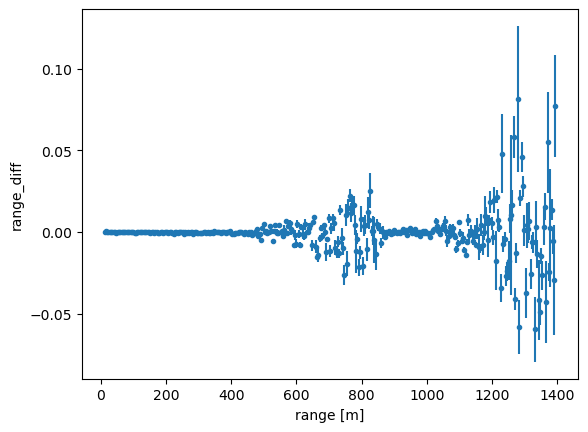

In [13]:
timestamp = ds.isel(time=1)
plt.errorbar(timestamp.profile_range,timestamp.range_diff,abs(timestamp.err),marker='.',linestyle='none')
plt.xlabel('range [m]')
plt.ylabel('range_diff')

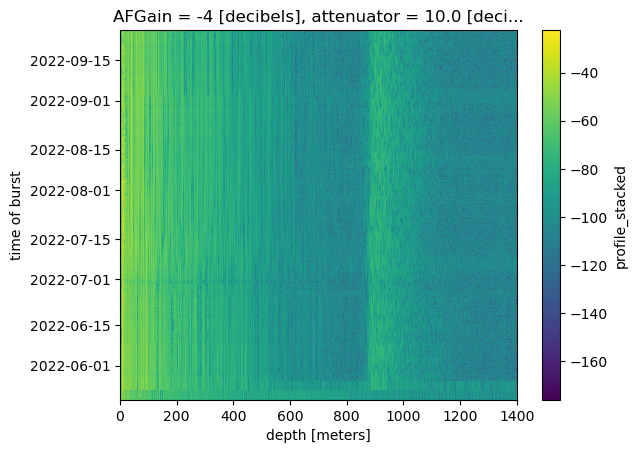

In [27]:
xa.dB(timeseries).plot()

In [4]:
timeseries = ds_104.isel(attenuator_setting_pair = 0,time=range(100,len(ds_104.time))).profile_stacked.compute()


In [5]:
b1 = timeseries.isel(time=range(0,len(timeseries.time)-1))
b2 = timeseries.isel(time=range(1,len(timeseries.time)))

In [6]:
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)

INFO     15:55:20 	 ApRESDefs.py @function generate_range_diff line 545 - Time between bursts : [899. 900. 888. ... 903. 905. 897.]s


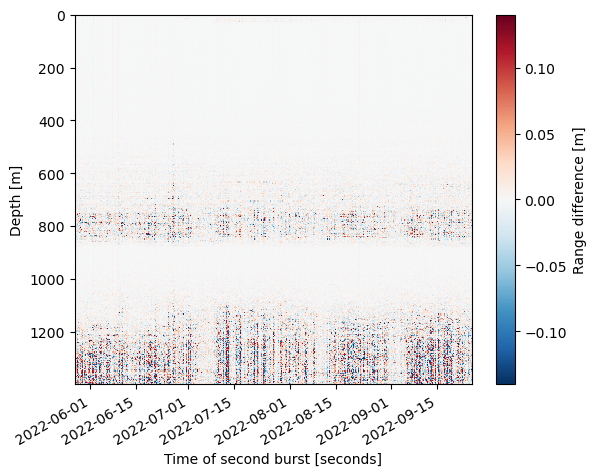

In [8]:
ds.range_diff.plot(x='time')
plt.gca().invert_yaxis()

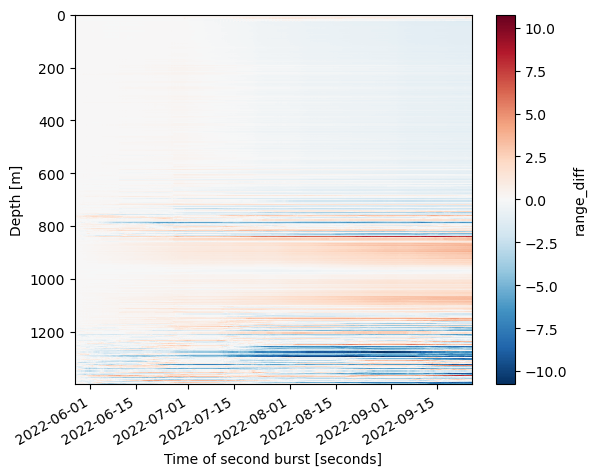

In [9]:
ds.range_diff.cumsum(dim='time').plot(x='time')
plt.gca().invert_yaxis()

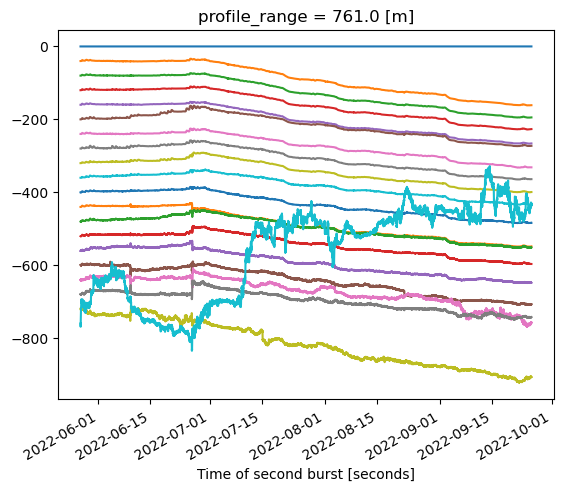

In [7]:
for i in np.arange(0,200,10):
    (100*ds.range_diff.cumsum(dim='time').isel(profile_range = i) - ds.range_diff.profile_range.isel(profile_range = i)).plot()


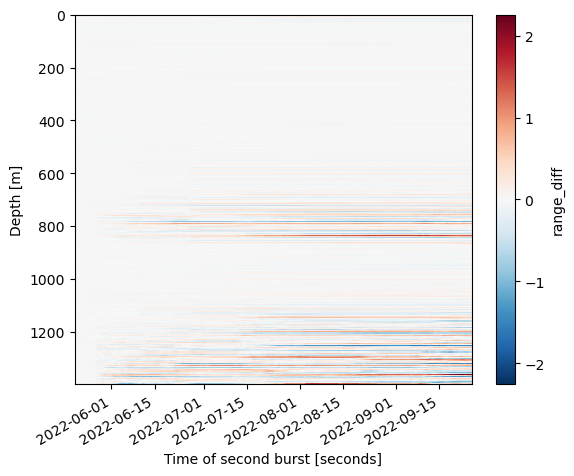

In [33]:
(ds.range_diff.cumsum(dim='time')).differentiate('profile_range').plot(x='time')
plt.gca().invert_yaxis()

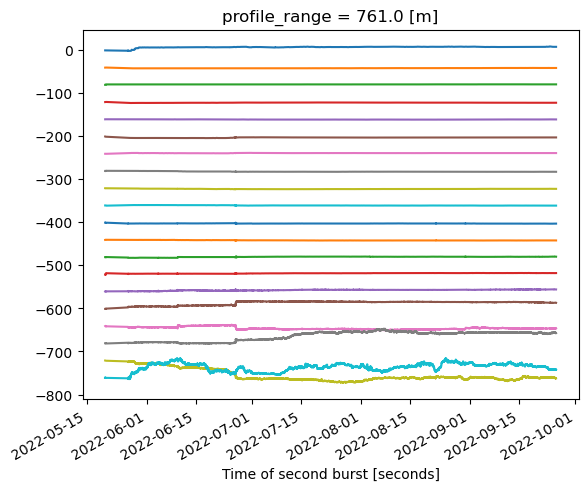

In [52]:
for i in np.arange(0,200,10):
    (100*ds.range_diff.cumsum(dim='time').differentiate('profile_range').isel(profile_range = i) - ds.range_diff.profile_range.isel(profile_range = i)).plot()


In [86]:
profiles_hourly = ds_101.isel(attenuator_setting_pair=1,chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1D').mean(dim='time').compute()


In [87]:
date_range = xr.date_range('2022-07-01T12:00:00.000000000','2022-07-30T12:00:00.000000000',freq='1D')
profiles_hourly_crop =timeseries.sel(time=date_range,method='nearest')

In [88]:
b1 = profiles_hourly_crop.isel(time=range(0,len(profiles_hourly_crop.time)-1)).where(profiles_hourly_crop.profile_range >= 10,drop=True)
b2 = profiles_hourly_crop.isel(time=range(1,len(profiles_hourly_crop.time))).where(profiles_hourly_crop.profile_range >= 10,drop=True)

In [89]:
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)

INFO     21:24:57 	 ApRESDefs.py @function generate_range_diff line 550 - Time between bursts : [86431. 86366. 86435. 86400. 86368. 86399. 86402. 86408. 86395. 86408.
 86388. 86409. 86423. 86400. 86372. 86399. 86402. 86442. 86357. 86401.
 86402. 86400. 86407. 86395. 86399. 86400. 86401. 86405. 86406.]s


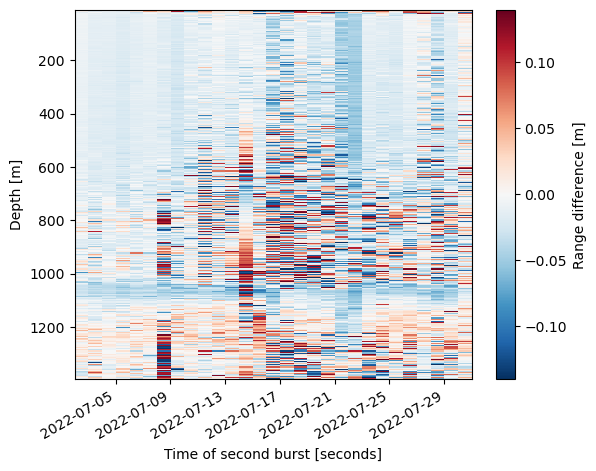

In [90]:
ds.range_diff.plot(x='time')
plt.gca().invert_yaxis()

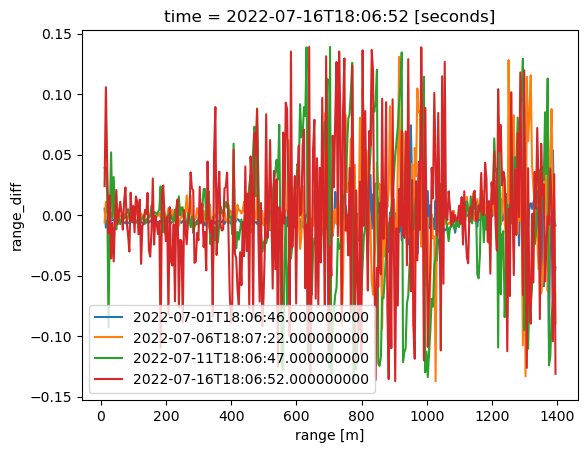

In [85]:
for i in 20*np.arange(0,4):
    ds.isel(time=i).range_diff.plot(label=f'{ds.isel(time=i).time.data}')
plt.xlabel('range [m]')
plt.ylabel('range_diff')
plt.legend()

In [80]:
ds

<xarray.Dataset>
Dimensions:        (time: 116, profile_range: 220)
Coordinates:
  * time           (time) datetime64[ns] 2022-07-01T18:06:46 ... 2022-07-30T1...
  * profile_range  (profile_range) float64 13.25 19.56 ... 1.389e+03 1.395e+03
Data variables:
    time_diff      (time) float64 2.16e+04 4.32e+04 ... 2.484e+06 2.506e+06
    range_diff     (time, profile_range) float64 0.00206 -0.005812 ... -0.05061
    err            (time, profile_range) float64 0.003818 0.001854 ... 0.02794